# Plotting and analyzing the results

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Overview of required files](#required_files)
3. [Plotting the results](#plotting)\
   3.1. [Energy vs time](#ene_time)\
   3.2. [Average partial density of states](#ave_pdos)
      * 3.2.1. [Orbital resolved](#ave_pdos_1)
      * 3.2.2. [Atom resolved](#ave_pdos_2)
     
   3.3. [Excitation analysis](#exc_analysis)\
   3.4. [NAC map](#nac_map)\
   3.5. [NAMD results](#namd_res)
   
### A. Learning objectives

* To be able to plot the average partial density of states
* To be able to plot the computed excited states energies vs time
* To be able to plot the average CI coefficients
* To be able to plot the NAC map
* To be able to plot and analyze NAMD results

### B. Use cases


* [Plotting the results](#plotting)


### C. Functions

- `libra_py`
  - `data_stat`
    - [`cmat_distrib`](#nac_dist)
  - `workflows`
    - `nbra`
      - [`step2_many_body`](#exc_anal)
        - [`normalize_ci_coefficients`](#exc_anal)
      - [`step3`](#comp_nacs)
        - [`run_step3_ks_nacs_libint`](#KS)
        - [`run_step3_sd_nacs_libint`](#excited_states)
  - `packages`
    - `cp2k`
      - `methods`
        - [`read_cp2k_tddfpt_log_file`](#exc_anal)
  - `units`
    - `au2ev`

## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Since the data are stored in sparse format using `scipy.sparse` library, we need to load this library so that we can read the data. Import `numpy`, `scipy.sparse`, `CP2K_methods`, `data_stat`, `units`, and `step2_many_body` modules. `glob` library will be needed to find specific types of files and `scipy.optimize.curve_fit` will be used to fit the NAMD results.

In [10]:
import os, sys
import glob
import h5py
import numpy as np
import scipy.sparse as sp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from libra_py import units, data_stat
import libra_py.packages.cp2k.methods as CP2K_methods
from libra_py.workflows.nbra import step2_many_body

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

All of the pdos files are stored in this folder:

* `../7_step2_cp2k/1_DFT/2_hpc/1_example_TiO2/all_pdosfiles`

All the logfiles containing the excitation analysis data are stored in this folder:

* `../7_step2_cp2k/1_DFT/2_hpc/1_example_TiO2/all_logfiles`

All of the time-overlaps and nonadiabatic coupling matrices are stored in the cuurent directory and this folder:

* `res-mb-sd-DFT`

## 3. Plotting the results <a name="plotting"></a>
[Back to TOC](#toc)


### 3.1. Energy vs time <a name="ene_time"></a>

Here, we will plot the energies of the many-body and single-particle excitation bases

<IPython.core.display.Javascript object>


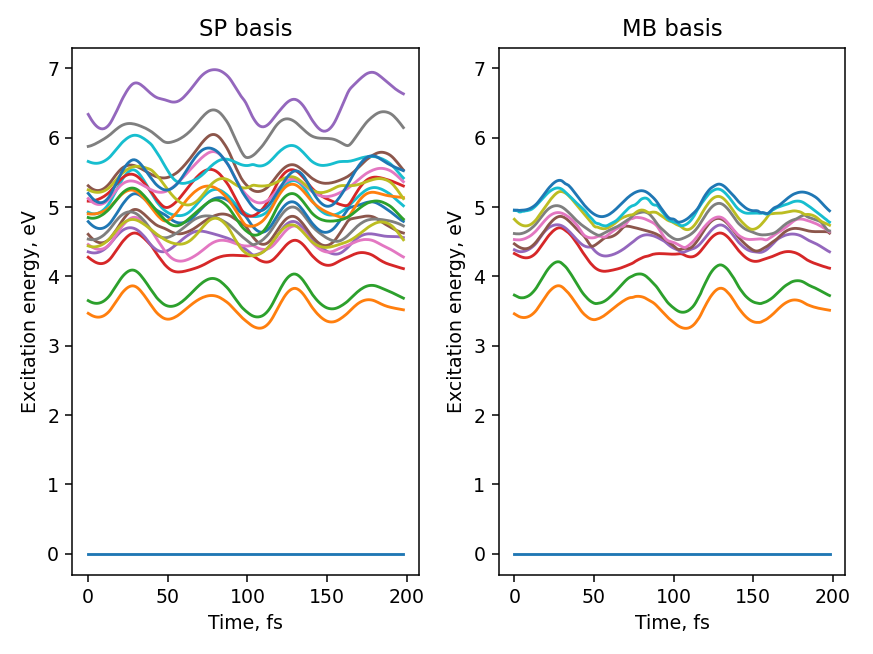

In [3]:
%matplotlib notebook
titles = ['SP basis', 'MB basis']
plt.figure()
for c, basis in enumerate(['sd','ci']):
    plt.subplot(1,2,c+1)
    #energy_files = glob.glob(F'res-mb-sd-DFT/Hvib_{basis}*re*')
    #energy_files = data_io.sort_hvib_file_names(energy_files)
    #print('Sorted energy files are:', energy_files)
    dt = 1.0 # fs
    energies = []
    for step in range(1200,1399):
        file = F'res-mb-sd-DFT/Hvib_{basis}_{step}_re.npz'
        energies.append(np.diag(sp.load_npz(file).todense().real))
    energies = np.array(energies)*units.au2ev
    md_time = np.arange(0,energies.shape[0]*dt,dt)
    for i in range(energies.shape[1]):
        plt.plot(md_time, energies[:,i]-energies[:,0])
    
    plt.title(titles[c])
    plt.ylabel('Excitation energy, eV')
    plt.xlabel('Time, fs')
    plt.ylim(-0.3, 7.3)
plt.tight_layout()

### 3.2. Average density of states <a name="ave_pdos"></a>

In this section, we will plot the average partial density of states (pDOS) over the MD trajectory. There are two ways to take the average of the pDOS:

1- Average all the pDOS files and then convolve the average pDOS for each element.
2- Convolve the pDOS files and then take the average for each element.

We choose the first one due to two reasons. First, the computational cost is much lower and we only need one convolution. Second is that averaging over the grid points (using the method 2) is dependent on the number of grid points we use for convolution which again adds to the complexity of the procedure. 

Here, we will use normalized Gaussian function for weighting the pDOS values and summing them.

$$f(x)=\frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x-\mu)^2}{2\sigma^2})$$

This function is defined in the `gaussian_function` below. To apply this to a vector of numbers and sum all the weighted Gaussians, we use the `gaussian_function_vector` which will be used for pDOS plots.

In [4]:
def gaussian_function(a, mu, sigma, num_points, x_min, x_max):
    pre_fact = (a/sigma)/(np.sqrt(2*np.pi))
    x = np.linspace(x_min, x_max, num_points)
    x_input = np.array((-1/2)/(np.square(sigma))*np.square(x-mu))
    gaussian_fun = pre_fact*np.exp(x_input)
    
    return x, gaussian_fun
    
def gaussian_function_vector(a_vec, mu_vec, sigma, num_points, x_min, x_max):
    for i in range(len(a_vec)):
        if i==0:
            sum_vec = np.zeros(num_points)
        energy_grid, conv_vec = gaussian_function(a_vec[i], mu_vec[i], sigma, num_points, x_min, x_max)
        sum_vec += conv_vec
    return energy_grid, sum_vec

#### 3.2.1. Orbital resolved <a name="ave_pdos_1"></a>
[Back to TOC](#toc)

In this part, we plot the pDOS for all of the angular momentum components of each atom. This is done by using the `orbital_cols`. In fact, the `orbital_cols` is related to `orbitals`. For example, for `s` orbital, we consider the 3rd index and for `p` orbital, we sum the columns from 4 to 6 (`range(4,7)`). Here we want to show how the code works and how the you can modify that based on your project. In the next section, we will show the pDOS only for atoms and sum all the components in each row of the pdos file. Other parameters are as follows:

`atoms`: The atoms names which will be used in the labeling and plotting. The atoms order should be exactly the same as appear in the `.pdos` files. For example, the `*k1*.pdos` files contain the pDOS data for `Ti` atom and `*k2*.pdos` files contain the data for the `O` atom.

`npoints`: The number of grid points for making the Gaussian functions. Note that, this value should be more than the number of states in the `.pdos` files.

`sigma`: The standard deviation in eV.

`shift`: This value shifts the minimum and maximum energy found in the `pdos_ave` and will extend the boundaries from both sides by `shift`eV.

Finally, we will plot the total density of states. Note that the HOMO energy level is set to zero.

<IPython.core.display.Javascript object>


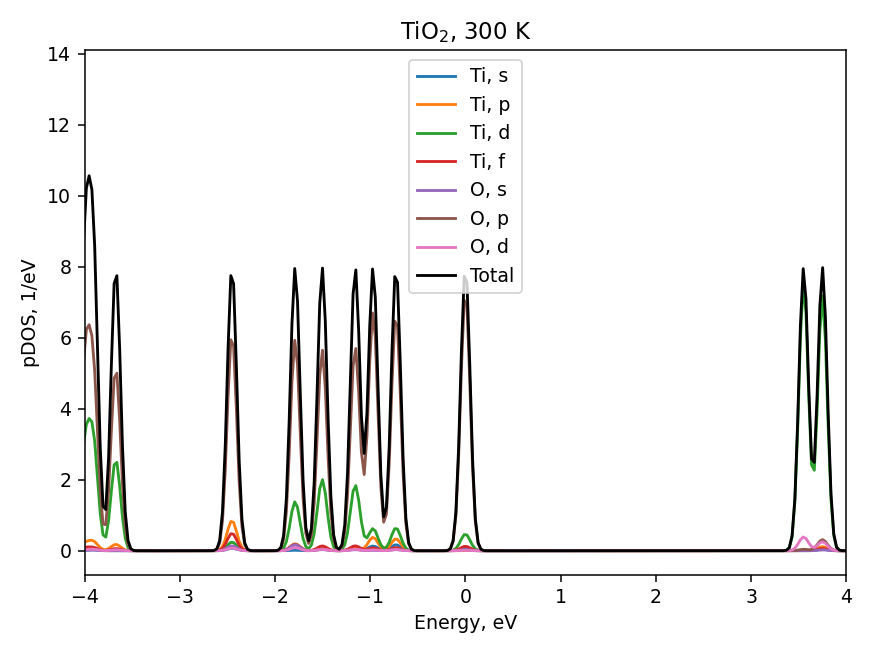

In [14]:
%matplotlib notebook
path_to_all_pdos = 'data/all_pdosfiles'
atoms = ['Ti', 'O']
orbitals_cols = [[3], range(4,7), range(7,12), range(12,19)]
orbitals = ['s','p','d','f']
npoints = 4000
sigma = 0.05 # eV
shift = 2.0 # eV
ave_pdos_convolved_all = []


for c1,i in enumerate([1,2]):
    # Finding all the pdos files
    pdos_files = glob.glob(path_to_all_pdos+F'/*k{i}*.pdos')
    pdos_ave = np.zeros(np.loadtxt(pdos_files[0]).shape)
    cnt = len(pdos_files)    
    for c2, pdos_file in enumerate(pdos_files):
        pdos_mat = np.loadtxt(pdos_file)        
        if c2==0:
            pdos_ave = np.zeros(pdos_mat.shape)
        pdos_ave += pdos_mat 
    pdos_ave /= cnt    
    pdos_ave[:,1] *= units.au2ev
    e_min = np.min(pdos_ave[:,1])-shift
    e_max = np.max(pdos_ave[:,1])+shift
    homo_level = np.max(np.where(pdos_ave[:,2]==2.0))
    homo_energy = pdos_ave[:,1][homo_level]
    for c3, orbital_cols in enumerate(orbitals_cols):
        try:
            sum_pdos_ave = np.sum(pdos_ave[:,orbital_cols],axis=1)
            ave_energy_grid, ave_pdos_convolved = gaussian_function_vector(sum_pdos_ave, pdos_ave[:,1], sigma,
                                                                               npoints, e_min, e_max)
            ave_pdos_convolved_all.append(ave_pdos_convolved)
            pdos_label = atoms[c1]+F', {orbitals[c3]}'
            plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved, label=pdos_label)
        except:
            pass


ave_pdos_convolved_total = np.sum(np.array(ave_pdos_convolved_all),axis=0)
plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved_total, color='black', label='Total')
plt.legend()
plt.xlim(-4,4)
plt.ylabel('pDOS, 1/eV')
plt.xlabel('Energy, eV')
plt.title('TiO$_2$, 300 K')
plt.tight_layout()

#### 3.2.2. Atom resolved <a name="ave_pdos_2"></a>
[Back to TOC](#toc)

As you can see we have removed the `for` loop for the `orbital_cols` and in the `try` section we have set `sum_pdos_ave = np.sum(pdos_ave[:,3::],axis=1)` which will sum all the columns from 3rd index (`pdos_ave[:,3::]`).


<IPython.core.display.Javascript object>


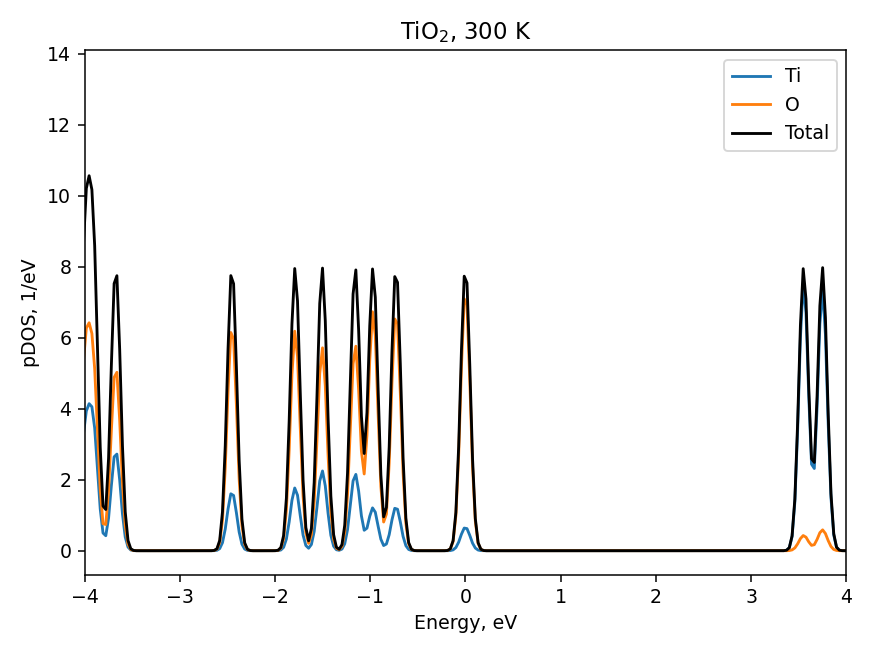

In [15]:
%matplotlib notebook
path_to_all_pdos = "data/all_pdosfiles"
atoms = ['Ti', 'O']
npoints = 4000
sigma = 0.05
shift = 2.0 # eV
ave_pdos_convolved_all = []

for c1,i in enumerate([1,2]):
    pdos_files = glob.glob(path_to_all_pdos+F'/*k{i}*.pdos')
    for c2, pdos_file in enumerate(pdos_files):
        pdos_mat = np.loadtxt(pdos_file)
        if c2==0:
            pdos_ave = np.zeros(pdos_mat.shape)
        pdos_ave += pdos_mat
    pdos_ave /= c2+1
    pdos_ave[:,1] *= units.au2ev
    e_min = np.min(pdos_ave[:,1])-shift
    e_max = np.max(pdos_ave[:,1])+shift
    homo_level = np.max(np.where(pdos_ave[:,2]==2.0))
    homo_energy = pdos_ave[:,1][homo_level]
    try:
        sum_pdos_ave = np.sum(pdos_ave[:,3::],axis=1)
        ave_energy_grid, ave_pdos_convolved = gaussian_function_vector(sum_pdos_ave, pdos_ave[:,1], sigma,
                                                                           npoints, e_min, e_max)
        ave_pdos_convolved_all.append(ave_pdos_convolved)
        pdos_label = atoms[c1]
        plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved, label=pdos_label)
    except:
        pass


ave_pdos_convolved_total = np.sum(np.array(ave_pdos_convolved_all),axis=0)
plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved_total, color='black', label='Total')
plt.legend()
plt.xlim(-4,4)
plt.ylabel('pDOS, 1/eV')
plt.xlabel('Energy, eV')
plt.title('TiO$_2$, 300 K')
plt.tight_layout()

### 3.3. Excitation analysis <a name="exc_analysis"></a>
[Back to TOC](#toc)

Here, we average the CI coefficients for each TD-DFT excited states over the MD trajectory. This shows the excited states degree of mixing. This code is adopted from [here](https://github.com/AkimovLab/Project_CsPbI3_MB_vs_SP/blob/master/cubic/excitation_analysis/excitation_analysis.py) written by Dr. Brendan Smith with some modifications.

We first need to define a dictionary which has exactly the same parameters as in `params_md_sd`. Other parameters that needs to be defined are as follows:

`logfiles`: A list of all log files which is obtained from `glob.glob`.

`nsds`: Number of SDs to be considered for each excited state.

`colors`: The colors which are in order of the SDs. For example, the `green` color is for the first excitation that appears in the excited states analysis section in CP2K log files.

The black lines show the error bars which are computed with a confidence interval coefficient of 1.96 which shows the confidence interval of $95\%$. The error bars are computed as follows:

$$\epsilon=Z\frac{s}{\sqrt{N}}$$

where $Z$ is the confidence interval coefficient, $s$ is the standard deviation of the $c_i^2$ values, and $N$ is the number of samples. We will use this formula over the tutorials for step4 as well.

<IPython.core.display.Javascript object>


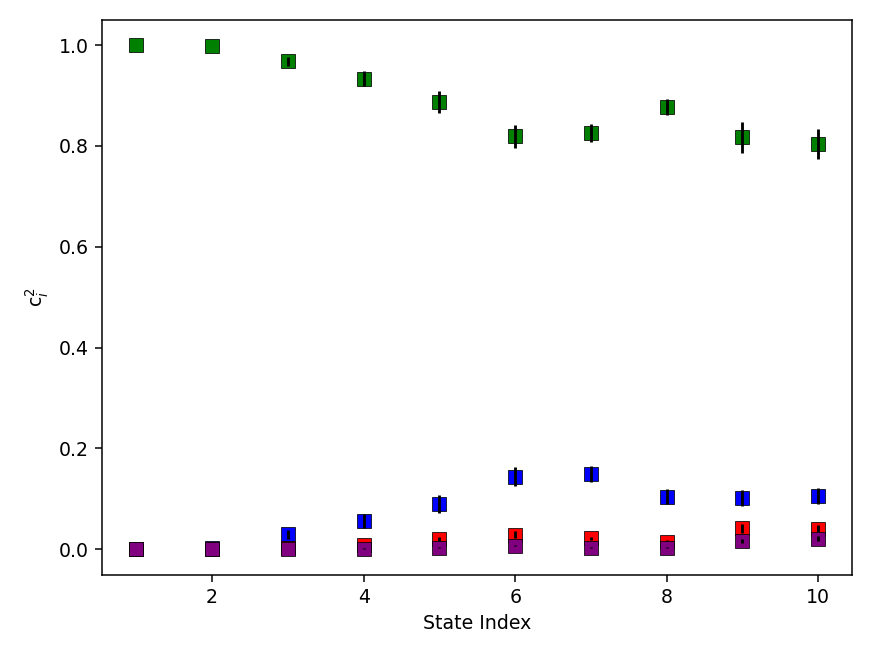

In [17]:
%matplotlib notebook
logfiles = glob.glob("data/all_logfiles/*.log")
nsds = 4
nstates = 10
colors = ['green','blue','red','purple']
params = {'isUKS': 0, 'number_of_states': 10, 'tolerance': 0.01, 'logfile_name': ''}
ci_coeffs = []
for logfile in logfiles:
    params.update({"logfile_name": logfile})
    excitation_energies, ci_basis_raw, ci_coefficients_raw_unnorm, spin_components = CP2K_methods.read_cp2k_tddfpt_log_file( params ) 
    ci_coefficients_raw_norm = step2_many_body.normalize_ci_coefficients(ci_coefficients_raw_unnorm)
    for j in range(len(ci_coefficients_raw_norm)):
        for k in range(len(ci_coefficients_raw_norm[j])):
            ci_coefficients_raw_norm[j][k] = ci_coefficients_raw_norm[j][k]**2
    ci_coeffs.append(ci_coefficients_raw_norm)


nsteps = len(ci_coeffs)

coeffs = []
coeffs_avg   = []
coeffs_error = []


for state in range(nstates):
    coeffs.append( [] )
    coeffs_avg.append( [] )
    coeffs_error.append( [] )

    for sd in range( nsds ):

        coeffs[state].append( [] )
        coeffs_avg[state].append( [] )
        coeffs_error[state].append( [] )

        for step in range( nsteps ):
            if len( ci_coeffs[step][state] ) < nsds and sd > len( ci_coeffs[step][state] )-1:
                coeffs[state][sd].append( 0.0 )
            else:
                coeffs[state][sd].append( ci_coeffs[step][state][sd] )
     
        mb_coeff_avg, mb_coeff_std = data_stat.scalar_stat( coeffs[state][sd] )
        coeffs_avg[state][sd].append( mb_coeff_avg )
        coeffs_error[state][sd].append( 1.96 * mb_coeff_std / np.sqrt(nsteps) )
  
        plt.plot(     state+1, mb_coeff_avg, color="black", marker='s', markerfacecolor=colors[sd], markeredgewidth=0.4, markersize=7)
        plt.errorbar( state+1, mb_coeff_avg, yerr=coeffs_error[state][sd], linestyle="None", color='black')


# plt.ylim(0,1)
plt.xlabel('State Index')
plt.ylabel('c$_{i}^2$')
plt.tight_layout()

### 3.4. NAC map <a name="nac_map"></a>
[Back to TOC](#toc)

One way of visualizing the NAC values is to plot the average NAC matrix using `plt.imshow`.

<IPython.core.display.Javascript object>


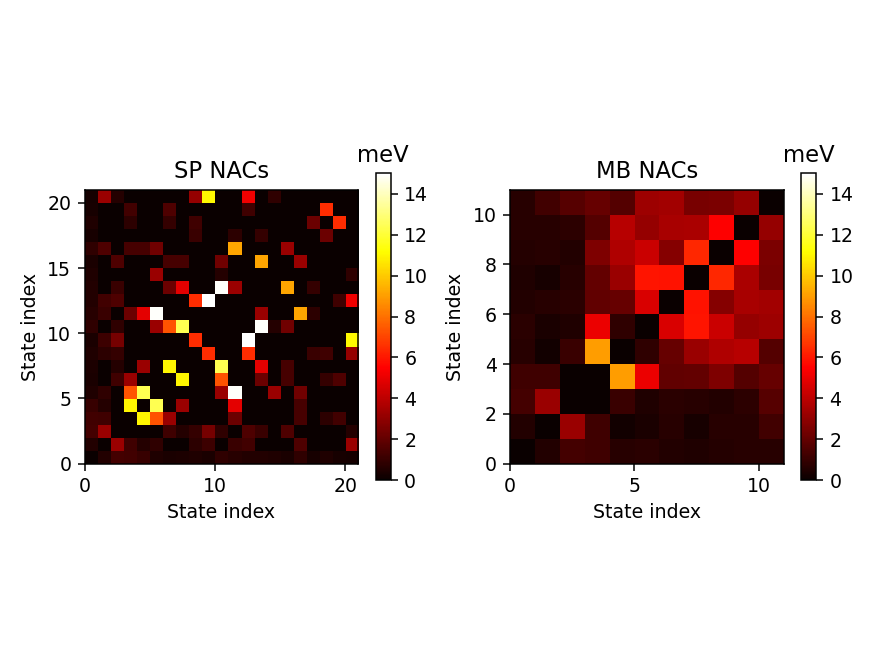

In [18]:
%matplotlib notebook
plt.figure()
titles = ['SP','MB']
for c1, basis in enumerate(['sd', 'ci']):
    plt.subplot(1, 2, c1+1)
    nac_files = glob.glob(F'res-mb-sd-DFT/Hvib_{basis}*im*')
    for c2, nac_file in enumerate(nac_files):
        nac_mat = sp.load_npz(nac_file).todense().real
        if c2==0:
            nac_ave = np.zeros(nac_mat.shape)
        nac_ave += np.abs(nac_mat)
    nac_ave *= 1000*units.au2ev/c2
    nstates = nac_ave.shape[0]
    plt.imshow(np.flipud(nac_ave), cmap='hot', extent=(0,nstates,0,nstates))#, vmin=0, vmax=100)
    plt.xlabel('State index')
    plt.ylabel('State index')
    colorbar = plt.colorbar(shrink=0.50)
    colorbar.ax.set_title('meV')
    plt.clim(vmin=0, vmax=15)
    plt.title(F'{titles[c1]} NACs')
    plt.tight_layout()

## NAMD results <a name="namd_res"></a>
[Back to TOC](#toc)


After the dynamic is done, we load all the NA-MD results, stored in `NBRA_icond_*/mem_data.hdf` files, using `h5py` and start fitting them to a exponential function of the form:

$$P(t; E_0)=\exp(-(\frac{t}{\tau})^2)$$


Then, the average time scale is computed for the fits that has an $R^2$ value more than $0.1$. The error bars are computed using the following formula as above:

$$\epsilon=Z\frac{s}{\sqrt{N}}$$

where $s$ is the stadard deviaton and $N$ is the number of samples (the ones that have $R^2$ value of more than $0.1$). The $Z$ value is the confidence interval coefficient which for confidence interval of $95\%$, a value of $1.96$ is chosen.

In above, we will consider the recovery dynamics population of the first and second excited states. Also, please note that this is just an example and we want to show how the workflow is. So, we consider a low $R^2$ value. For better and more accurate results, we need not only longer trajectory but also larger number of surface hopping trajectory.


In [19]:
def exp_func(t, tau):
    return np.exp(-np.power(t/tau,2))

tau: [2793.56126099]  R2: 0.3773919447951464


<IPython.core.display.Javascript object>


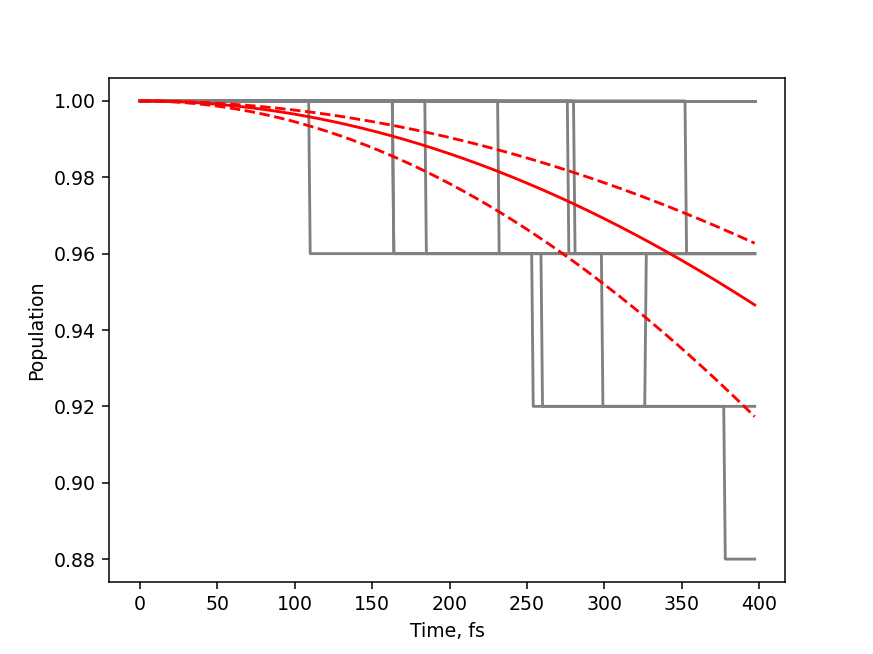

tau: [1574.24433586]  R2: 0.5653939659941569
tau: [1898.81543752]  R2: 0.7058661874681196
tau: [15499.93429735]  R2: -inf
tau: [1186.91015155]  R2: 0.9056004562663681
tau: [1375.6635346]  R2: 0.46420836410470556
tau: [15499.93429735]  R2: -inf
tau: [1701.25301025]  R2: 0.7553743418477212
tau: [1145.67369702]  R2: 0.7499029310211452
tau: [1876.93948556]  R2: 0.7151151021839184
The timescales: 1694.1326141689817+-342.8236442804993 fs, averaged over 8 samples


/home/alexvakimov/SOFTWARE/Conda/envs/libra/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  


In [20]:
%matplotlib notebook
dt = 1
taus = []
for icond in range(0,199,20):
    F = h5py.File(F'NBRA_icond_{icond}/mem_data.hdf')
    sh_pop = np.array(F['sh_pop_adi/data'])
    F.close()
    md_time = np.arange(0,sh_pop.shape[0])*dt
    pop_recov = 1-np.sum(sh_pop[:,[1,2]], axis=1)
    popt, pcov = curve_fit( exp_func, md_time, pop_recov, bounds=([0.0],[np.inf]))
    tau = popt
    # Computing the R-squared
    residuals  = pop_recov - exp_func(md_time, *popt)
    ss_res     = np.sum(residuals**2)
    ss_tot     = np.sum((pop_recov - np.mean(pop_recov))**2)
    r_squared  = 1.0 - (ss_res / ss_tot)
    print('tau:', tau,  ' R2:', r_squared)

    if r_squared>0.1:
        taus.append(tau)
    plt.plot(md_time, pop_recov, color='gray')
plt.ylabel('Population')
plt.xlabel('Time, fs')

taus = np.array(taus)
ave_tau = np.average(taus)
s = np.std(taus)
Z = 1.96
N = taus.shape[0]
error_bar = Z*s/np.sqrt(N)
print(F'The timescales: {ave_tau}+-{error_bar} fs, averaged over {len(taus)} samples')
plt.plot(md_time, exp_func(md_time, ave_tau-error_bar), ls='--', color='red')
plt.plot(md_time, exp_func(md_time, ave_tau), ls='-',  color='red')
plt.plot(md_time, exp_func(md_time, ave_tau+error_bar), ls='--', color='red')